In [1]:
!pip install git+https://github.com/kaanaksit/odak.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/kaanaksit/odak.git to /tmp/pip-req-build-7czk2cwj
  Running command git clone -q https://github.com/kaanaksit/odak.git /tmp/pip-req-build-7czk2cwj
     |████████████████████████████████| 3.1 MB 9.7 MB/s 
  Created wheel for odak: filename=odak-0.2.1-py3-none-any.whl size=116322 sha256=ae24f8863703093daa0505837adecbfea65c4748759d435f7dac558a9151b01d
  Stored in directory: /tmp/pip-ephem-wheel-cache-jrnsmuvq/wheels/d5/00/3c/4e341f18b6968ce909001cd30304934b45bdbb5e38ae6c41b5
Successfully built odak
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [2]:
import odak
import torch 
import numpy as np 
import sys
import odak.learn.raytracing as ODL
import matplotlib.pyplot as plt
import math
import odak.raytracing as raytracer
import odak.tools as tools
import odak.raytracing as raytracer
from odak.raytracing.ray import create_ray
import cv2
import sys
import torch.optim as optim
import math

In [28]:
import sys
class aperture_array():

  def __init__(self, device, image):
    self.device = device
    self.image =image.to(device).view(-1,1)
    self.init_light_sources()
    self.init_aperture_array()
    self.init_detector()
  
  def init_light_sources(self, dimensions=[0.01, 0.015], pixel_count=[20, 30], Z=0.):
      x = torch.linspace(-dimensions[0]/2., dimensions[0]/2., pixel_count[0])
      y = torch.linspace(-dimensions[1]/2., dimensions[1]/2., pixel_count[1])
      X, Y = torch.meshgrid(x, y, indexing='ij')
      self.light_source_locations = torch.zeros(X.shape[0], X.shape[1], 3).to(self.device)
      self.light_source_locations[:, :, 0] = X
      self.light_source_locations[:, :, 1] = Y
      self.light_source_locations[:, :, 2] = Z
      
      
  def init_aperture_array(self, dimensions=[0.01, 0.015], pixel_count=[20, 30], Z=0.01):
        x = torch.linspace(-dimensions[0]/2., dimensions[0]/2., pixel_count[0])
        y = torch.linspace(-dimensions[1]/2., dimensions[1]/2., pixel_count[1])
        X, Y = torch.meshgrid(x, y, indexing='ij')
        self.aperture_array_locations = torch.zeros(X.shape[0], X.shape[1], 3).to(self.device)
        self.aperture_array_locations[:, :, 0] = X
        self.aperture_array_locations[:, :, 1] = Y
        self.aperture_array_locations[:, :, 2] = Z
        self.aperture_array = torch.rand(X.shape[0], X.shape[1], requires_grad=True, device=self.device)  #.to(self.device) # makes it differentiable
        plt.imshow(self.aperture_array.detach().cpu().numpy())
        
        
  def init_detector(self, dimensions=[0.01, 0.015], size=[20, 30], Z=0.01):
        
        point = torch.tensor([0., 0., Z]).to(self.device)
            #Look into this defination again
        self.detector_surface = odak.learn.raytracing.define_plane(point)
        
        
        # Locations of my pixels on my detector could be defined here.
        
  def intersection_points_to_image(self, points, amplitudes, threshold):
   
        Points_data= self.image
        detector = torch.zeros_like(Points_data)
        array_locations = self.aperture_array_locations.view(-1, 3)

        for idx, point in enumerate(points):
          
      
          dist_btwn_array_npoint = torch.sqrt(torch.sum((array_locations-point)**2, dim=1))
          min_dist_idx  = torch.argmin(dist_btwn_array_npoint)
          min_dist = torch.min(dist_btwn_array_npoint)

          if min_dist < (math.sqrt(2) * threshold):
            detector[min_dist_idx] = Points_data[idx]
            #print(min_dist)
        detector= detector.view(20,30)
        return detector
  
  def forward(self):
        light_source_locations = self.light_source_locations.view(-1, 3)

        aperture_array_locations = self.aperture_array_locations.view(-1, 3)
      
        aperture_array = self.aperture_array.view(-1, 1)
        detector_image  = torch.zeros(20, 30).to(self.device)
        
        pixel_pitch = torch.sqrt(torch.sum((aperture_array_locations[1] - aperture_array_locations[0])**2, dim =0))
        
        for light_source_location in light_source_locations:
            rays_from_light_source = odak.learn.raytracing.create_ray_from_two_points(light_source_location, aperture_array_locations)

            # print('rays from light: ', rays_from_light_source.size()) #600x2x3
            intersection_normals_w_detector, _ = odak.learn.raytracing.intersect_w_surface(rays_from_light_source, self.detector_surface)
            intersection_points_w_detector = intersection_normals_w_detector[:, 0]
            
            # intersection_points.append(intersection_points_w_detector)
          # print(intersection_points_w_detector.size())
            detector_image += self.intersection_points_to_image(
                                                                intersection_points_w_detector,
                                                                aperture_array, 
                                                                pixel_pitch
                                                              )
            
       # print(intersection_normals_w_detector)
        # detector_image= detector_image.view(20,30)   
        return detector_image

  def compute_loss(self, output , target):

    loss = torch.nn.MSELoss()(output, target)

    return loss
            
  def optimize(self):

        output= self.forward().view(-1,1)
        target= self.image

        array = self.aperture_array
       
        optimiser= torch.optim.SGD([array],0.01)
        epochs= 100

        running_loss= 1
        for epoch in range(0, epochs+1):
          print('\rEpoch {}/{} - loss:{}'.format(epoch, epochs, running_loss/len(array)), end="")
          optimiser.zero_grad()
  
          

          loss = self.compute_loss(output.float(),target.float() )
          running_loss+= loss
          loss.backward(retain_graph=True)

          optimiser.step()

        return optimiser
  
def main():
    device = torch.device('cuda')
    apertures = aperture_array(device=device)
    result = apertures.optimize()
    return True


# if __name__ == '__main__':
#     sys.exit(main())






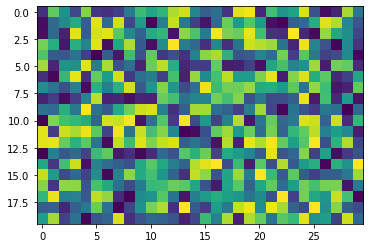

In [29]:
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/IP Labs/Images/Lenna.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray= cv2.resize(img_gray, (20, 30))
img_G= torch.tensor(img_gray)
# plt.imshow(img_gray, cmap='gray')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test= aperture_array(device, img_G)
final_im= test.forward()


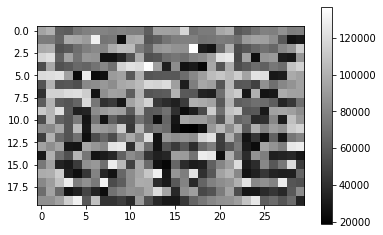

In [30]:
plt.imshow(final_im.cpu().detach().numpy(), cmap='gray')
plt.colorbar()

In [6]:
fin

NameError: ignored

In [ ]:
optim = test.optimize()